# Discrete Interactions

#### Adapted from Chapter 8 of Statistical Rethinking

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from theano import shared
import arviz as az
import seaborn as sns

In [2]:
def proc_data():
    data = pd.read_csv(os.path.join(os.getcwd(),r"data/rugged.csv"), delimiter=";")
    data['log_gdp'] = np.log(data['rgdppc_2000'])
    #subset on complete cases
    data.dropna(subset=['log_gdp'], inplace=True)
    #rescale
    data['log_gdp_std'] = data['log_gdp']/np.mean(data['log_gdp'])
    data['rugged_std'] = data['rugged']/np.max(data['rugged'])
    
    return data


In [3]:
d = proc_data()

In [4]:
def plotter(axs, axs_i, africa_flag, scatter_kwargs={}):
    sns.regplot(
    d.loc[d["cont_africa"]==africa_flag]["rugged_std"],
    d.loc[d["cont_africa"]==africa_flag]["log_gdp_std"],
    scatter_kws = scatter_kwargs,
    line_kws = {"color": "k"},
    ax = axs[axs_i]
    )

    
def country_labels(axs, axs_i, africa_flag, rugged_const, gdp_const):
    for _, df in d.loc[(d["rugged_std"] > 0.7) & (d["cont_africa"] == africa_flag)].iterrows():
        axs[axs_i].text(
            df["rugged_std"] + rugged_const,
            df["log_gdp_std"] - gdp_const,
            df["country"],
            ha = "center",
        )
    

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


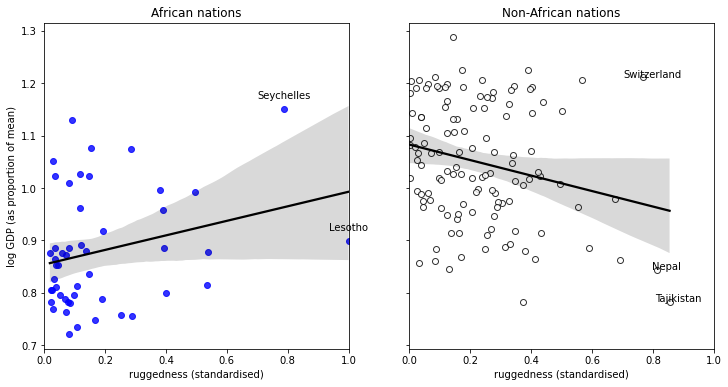

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)

plotter(axs, 0, 1, {"color": "b"})
plotter(axs, 1, 0, {"edgecolor": "k", "facecolor": "w"})

axs[0].set_ylabel("log GDP (as proportion of mean)")
axs[1].set_ylabel("")
axs[0].set_title("African nations")
axs[1].set_title("Non-African nations")

country_labels(axs, 0, 1, 0, -0.02)
country_labels(axs, 1, 0, 0.03, 0)

for ax in axs:
    ax.set_xlim(-0,1, 1.1)
    ax.set_xlabel("ruggedness (standardised)")

#### Start with the following model where $r_{i}$ is terrain ruggedness and $y_{i}$ is GDP for nation $i$, $\bar{r}$ is the average ruggedness for the entire sample@

$$log(y_{i}) \sim Normal(\mu_{i}, \sigma)$$
$$\mu_{i} = \alpha + \beta(r_{i}-\bar{r})$$

#### Which priors? Although we have little knowledge on the topic the scaled outcome variable and predictor makes it a little easier. With the mean centring of ruggedness $\alpha$ is the log GDP when ruggedness is at the sample mean which must be close to 1 since we scaled the outcome so that the mean is 1. We can therefore try:

$$\alpha \sim Normal(1,1)$$

#### For $\beta$ if we centre on zero that indicates no bias for positive or negative, for standard deviation we can try a value of 1.

$$\beta \sim Normal(0,1)$$

#### Finally assume the following for the error term:

$$\sigma \sim Exponential(1)$$

#### First let's examine priors

In [6]:
rugged_mu = np.mean(d["rugged_std"])

In [7]:
def get_prior_and_trace(a_mu, a_sd, b_mu, b_sd):
    with pm.Model() as model:
        a = pm.Normal("a", a_mu, a_sd)
        b = pm.Normal("b", b_mu, b_sd)

        mu = a + b*(d["rugged_std"] - rugged_mu)
        sigma = pm.Exponential("sigma", 1)

        log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=d["log_gdp_std"])
        
        model_trace = pm.sample()
        model_prior = pm.sample_prior_predictive()
    
    return model_trace, model_prior

In [12]:
_, m_8_1_prior = get_prior_and_trace(0, 1, 0, 1)

<ipython-input-7-a044891277ce>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  model_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [9]:
m_8_2_trace, m_8_2_prior = get_prior_and_trace(1, 0.1, 0, 0.3)

<ipython-input-7-a044891277ce>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  model_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [13]:
def plotter(ax_i, model_priors, plot_title):
    n = 100
    rugged_plot = np.linspace(-0.1, 1.1)
    ax_i.plot(
        rugged_plot,
        model_priors["a"][:n].T + rugged_plot.reshape(-1,1) * model_priors["b"][:n].T,
        color="k",
        lw=1,
        alpha=0.3)
    ax_i.set_title(plot_title)

In [16]:
az.summary(m_8_2_trace, kind='stats')

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a,1.000,0.011,0.980,1.019
b,0.002,0.056,-0.102,0.109
sigma,0.138,0.008,0.125,0.153


#### Two models have been built based on the equation above and then tighter priors on a and b. The prior predictive checks are plotted below with min and max bands on log GDP are also plotted (there's a simulated regression lines). The initial set of vague priors looks a bit all over the place whilst the second model looks that more plausible.

#### Remember: 95% of the Gaussian mass is within 2 standard deviations. So a Normal(0, 0.1) prior assigns 95% of the plausibility between 0.8 and 1.2. That is still very vague, but at least it isn’t ridiculous.

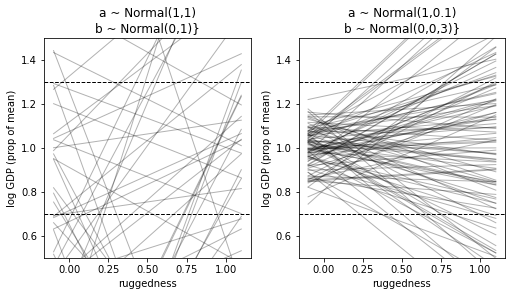

In [14]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=[7,4], constrained_layout=True)
plotter(ax1, m_8_1_prior, "a ~ Normal(1,1)\nb ~ Normal(0,1)}")
plotter(ax2, m_8_2_prior, "a ~ Normal(1,0.1)\nb ~ Normal(0,0,3)}")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_ylabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)    

#### How to add an indicator variable for African countries, conventionally we would do the following:
$$mu_{i} = \alpha + \beta(r_{i}-\bar{r}) + \gamma A_{i}$$

#### But the problem here is that we need a prior for $\gamma$ which captures the uncertainty in and outside of Africa. With the current specification however a prior on $\gamma$ would tell us that $\mu_{i}$ for a nation in Africa is more uncertain (before seeing the data) than outside of Africa. So to get around this we can grab an intercept for each partition:

$$mu_{i} = \alpha_{CID[i]} + \beta(r_{i}-\bar{r})$$

#### Where CID is continent ID taking the value 1 for African nations and 0 for all other nations.

In [21]:
cid = pd.Categorical(d.cont_africa)

In [28]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.shape[0])
    b = pm.Normal("b", 0, 0.3)
    
    mu = a[cid] + b*(d["rugged_std"] - rugged_mu)
    sigma = pm.Exponential("sigma", 1)
    
    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=d.log_gdp_std)
    
    m_8_3_trace = pm.sample()

<ipython-input-28-a9cd594e5707>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_8_3_trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### evaluate posterior means and respective credible intervalsm we now see two intercepts

In [29]:
az.summary(m_8_3_trace, kind="stats")

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a[0],1.049,0.010,1.029,1.068
a[1],0.880,0.017,0.850,0.911
b,-0.047,0.048,-0.134,0.042
sigma,0.114,0.007,0.103,0.127


#### Compare both models: difference in PSIS-LOO (and WAIC) is around 32 with a standard error of around 6.5. So the continent variable appears to be picking up some important association in the sample.

In [31]:
az.compare({"m_8_2": m_8_2_trace, "m_8_3": m_8_3_trace})

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_8_3,0,125.961687,4.324636,0.00000,0.966793,7.442211,0.000000,False,log
m_8_2,1,94.331277,2.673398,31.63041,0.033207,6.488730,7.353313,False,log


In [32]:
az.compare({"m_8_2": m_8_2_trace, "m_8_3": m_8_3_trace}, ic="waic")

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arvi

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_8_3,0,125.969235,4.317087,0.000000,0.966898,7.440106,0.000000,True,log
m_8_2,1,94.336884,2.667791,31.632351,0.033102,6.488257,7.352066,False,log


#### Let's examine the posterior and examine the posterior contrast between the two intercepts

In [43]:
with m_8_3:
    m_8_3_posterior = pm.sample_posterior_predictive(m_8_3_trace, var_names=["a", "b", "sigma"])



In [49]:
intercept_difference = m_8_3_posterior["a"][:, 1] - m_8_3_posterior["a"][:, 0]

#### The HDI indicates that the differenc is reliably less than zero

In [48]:
az.hdi(intercept_difference)

array([-0.20631301, -0.13190803])

#### Use retrodictions to see if the model manages to provide decent looking slopes inside and outside Africa. We see that maybe these reg lines aren't all that hot.

In [56]:
def retrodict_plotter(ax, _id, lab, plot, color, model_posterior):
    
    if lab == "Not Africa":
        ax.scatter(
            d.loc[cid==_id, "rugged_std"],
            d.loc[cid==_id, "log_gdp_std"],
            label = lab,
            facecolor = "w",
            lw = 1,
            edgecolor = "k",
        )
    else:
        ax.scatter(
            d.loc[cid==_id, "rugged_std"],
            d.loc[cid==_id, "log_gdp_std"],
            label = lab,
            color = color
        )
        
    pred = model_posterior["a"][:, _id] + plot.reshape(-1, 1)*model_posterior["b"]
    ax.plot(plot, pred.mean(1), color=color)
    az.plot_hdi(plot, pred.T, color=color, hdi_prob=0.97, ax=ax)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'log GDP (as proportion of mean)')

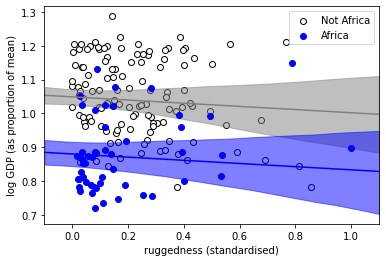

In [57]:
fig, ax = plt.subplots()
rugged_plot = np.linspace(-0.1, 1.1)

retrodict_plotter(ax, 0, "Not Africa", rugged_plot, "grey", m_8_3_posterior)
retrodict_plotter(ax, 1, "Africa", rugged_plot, "b", m_8_3_posterior)
ax.legend(frameon=True)
ax.set_xlim(-0.1, 1.1)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)")


#### The model indicates a rather week relationship between economic development and ruggedness of terrain, the dummy variable has allowed the model to predict a lower mean for African nations but as we see the slopes are parrellel. We should probably expect the slopes to be different, so we can do better than this.

#### A conventional approach may specify the following:
$$\mu_{i} = \alpha_{CID[i]}  + (\beta + \gamma A_{i})(r_{i} - \bar{r})$$
#### But again we choose the following for reasons discussed above:
$$\mu_{i} = \alpha_{CID[i]}  + \beta_{CID[i]}(r_{i} - \bar{r})$$


In [66]:
with pm.Model() as m_8_4:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.shape[0])
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.shape[0])
    
    sigma = pm.Exponential("sigma", 1)
    
    mu = a[cid] + b[cid]*(d["rugged_std"] - rugged_mu)
    
    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=d.log_gdp_std)
    
    m_8_4_trace = pm.sample(tune=1_000)
    

<ipython-input-66-5f7994c2769c>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  m_8_4_trace = pm.sample(tune=1_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


#### The slope is essentially reversed inside Africa, 0.13 instead of −0.14

In [61]:
az.summary(m_8_4_trace, kind="stats")

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
a[0],1.051,0.010,1.032,1.070
a[1],0.887,0.016,0.856,0.916
b[0],-0.143,0.057,-0.243,-0.031
b[1],0.132,0.078,-0.005,0.284
sigma,0.112,0.006,0.100,0.123


#### How much does allowing the slope to vary improve expected prediction. The additional interaction effect gives us the best model. Note  that these comparisons are not reliable guides to causal inference. They just tell us how important features are for prediction. Real causal effects may not be important for overall prediction in any given sample. Prediction and inference are just different questions. Still, overfitting always happens. So anticipating and measuring it matters for inference as well.

In [67]:
az.compare({"m_8_2": m_8_2_trace,"m_8_3": m_8_3_trace, "m_8_4": m_8_4_trace }, ic='loo', scale='deviance')

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arvi

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_8_4,0,-259.200102,4.967073,0.000000,8.918128e-01,14.615248,0.000000,False,deviance
m_8_3,1,-251.923373,4.324636,7.276729,1.081872e-01,14.884421,6.491663,False,deviance
m_8_2,2,-188.662554,2.673398,70.537548,2.220446e-16,12.977460,14.888632,False,deviance


In [68]:
m_8_4_loo_score = az.loo(m_8_4_trace, pointwise=True)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


#### plotting pointwise loo scores indicates observations with leverage, we should probably specify a prior to make the regression more robust (e.g. student T).

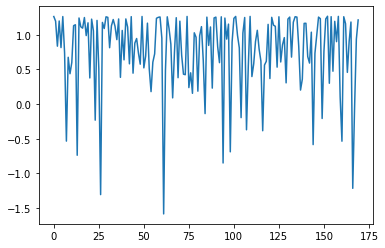

In [71]:
plt.plot(m_8_4_loo_score.loo_i)

In [79]:
with m_8_4:
    m_8_4_posterior = pm.sample_posterior_predictive(m_8_4_trace, var_names=["a", "b"])

In [88]:
def retrodict_plotter2(ax, _id, lab, plot, color, model_posterior):
    
    if lab == "Not Africa":
        ax.scatter(
            d.loc[cid==_id, "rugged_std"],
            d.loc[cid==_id, "log_gdp_std"],
            label = lab,
            facecolor = "w",
            lw = 1,
            edgecolor = "k",
        )
    else:
        ax.scatter(
            d.loc[cid==_id, "rugged_std"],
            d.loc[cid==_id, "log_gdp_std"],
            label = lab,
            color = color
        )
        
    pred = model_posterior["a"][:, _id] + plot.reshape(-1, 1)*model_posterior["b"][:, _id]
    ax.plot(plot, pred.mean(1), color=color)
    az.plot_hdi(plot, pred.T, color=color, hdi_prob=0.97, ax=ax)
    return pred

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


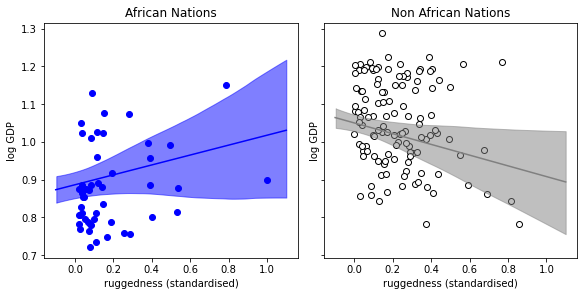

In [89]:
_, axes = plt.subplots(1, 2, figsize=[8,4], sharey=True, constrained_layout=True)
ax1, ax0 = axes
rugged_plot = np.linspace(-0.1, 1.1)

#retrodict_plotter(ax, 0, "Not Africa", rugged_plot, "grey", m_8_3_posterior)

pred_0 = retrodict_plotter2(ax0, 0, "Not Africa", rugged_plot, "grey", m_8_4_posterior)
ax0.set_title("Non African Nations")

pred_1 = retrodict_plotter2(ax1, 1, "Africa", rugged_plot, "b", m_8_4_posterior)
ax1.set_title("African Nations")

for i in axes:
    i.set_xlabel("ruggedness (standardised)")
    i.set_ylabel("log GDP")

#### Counterfactual plot - we compute the difference between a nation in African and outside Africa, holding ruggedness constant. The vertical axis is the difference in expected proportional log GDP for a nation in Africa and one outside Africa. At low ruggedness, we expect “moving” a nation to Africa to hurt its economy. But at high ruggedness, the opposite is true. The association between continent and economy depends upon ruggedness, just as much as the association between ruggedness and economy depends upon continent.

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


(0.0, 1.0)

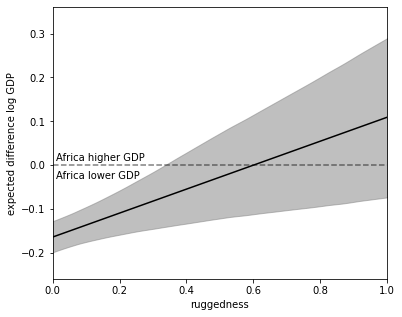

In [98]:
fig, ax = plt.subplots(figsize=(6,5))
rugged_plot = np.linspace(-0.1, 1.1)
delta = pred_1 - pred_0
ax.plot(rugged_plot, delta.mean(1), color='k')
az.plot_hdi(rugged_plot, delta.T, ax=ax, color="grey")

ax.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
ax.text(0.01, 0.01, "Africa higher GDP")
ax.text(0.01, -0.03, "Africa lower GDP")

ax.set_xlabel("ruggedness")
ax.set_ylabel("expected difference log GDP")
ax.set_xlim(0, 1)